In [33]:
import numpy as np
import matplotlib.pyplot as plt    
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures  

#for Franke function plot
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from random import random, seed

# For bootstrap 
from sklearn.utils import resample


### Franke function

(20,)


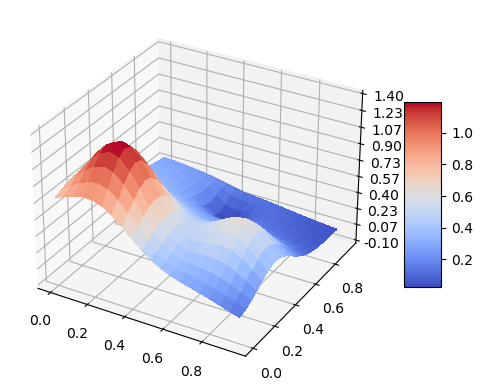

In [34]:
#Franke function - we want to fit polinomials to it by using OLS first

#shows plot within frontend and the resulting plot is stored in notebook document
%matplotlib inline 

fig = plt.figure()
ax = fig.add_subplot(projection='3d')

# Make data. Use alternatively the uniform distribution
x = np.arange(0, 1, 0.05)
print(x.shape)
y = np.arange(0, 1, 0.05)

# Using numpy's meshgrid
    #The numpy.meshgrid function is used to create a rectangular grid out of two given one-dimensional arrays representing the Cartesian indexing or Matrix indexing.
    #The output of coordinates by meshgrid can also be used for plotting functions within the given coordinate range. 
x, y = np.meshgrid(x,y)


def FrankeFunction(x,y):
    term1 = 0.75*np.exp(-(0.25*(9*x-2)**2) - 0.25*((9*y-2)**2))
    term2 = 0.75*np.exp(-((9*x+1)**2)/49.0 - 0.1*(9*y+1))
    term3 = 0.5*np.exp(-(9*x-7)**2/4.0 - 0.25*((9*y-3)**2))
    term4 = -0.2*np.exp(-(9*x-4)**2 - (9*y-7)**2)
    return term1 + term2 + term3 + term4


z = FrankeFunction(x, y)

# Plot the surface.
surf = ax.plot_surface(x, y, z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

# Customize the z axis.
ax.set_zlim(-0.10, 1.40)
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()

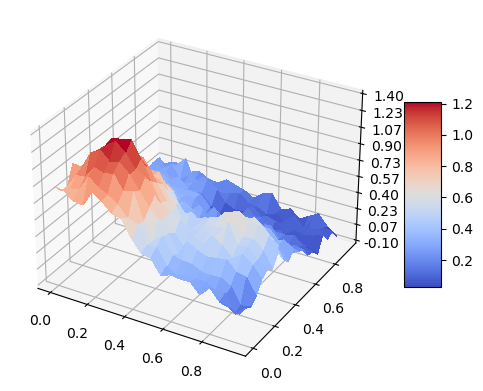

In [35]:
#Adding normally dstributed noise to the Franke function 

z_noise = np.random.normal(z, 0.05)

#z_noise = z+np.random.randn(len(z))

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
# Plot the surface.
surf_noise = ax.plot_surface(x, y, z_noise, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

ax.set_zlim(-0.10, 1.40)
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

# Add a color bar which maps values to colors.
fig.colorbar(surf_noise, shrink=0.5, aspect=5)

plt.show()

z_noise = z_noise.ravel()

In [36]:
#Define the Mean Squared Error function, the R2 score function and the mean value of the data

def MSE(y_data,y_model):
    N=np.size(y_model)
    return np.sum((y_data-y_model)**2)/N

def R2(y_data, y_model):
    return 1 - np.sum((y_data-y_model)**2)/np.sum((y_data- np.mean(y_data)**2))

def mean_data(y_data):
    N=np.size(y_data)
    return np.sum(y_data)/N

In [37]:
#here X is the design matrix and y is the output
        
def beta_calc(X, y):
    beta = np.linalg.inv(X.T@X) @X.T @ y
    return beta

In [38]:
# This function makes the design matrix for polynomials of order 5

"""
def Design_Matrix(x,y):
    x = x.ravel()       #ravel() creates a unique array
    y = y.ravel()
    length = len(x)
    X =np.stack((np.ones(length), x , y , 
                 x**2 , y**2 , x*y , 
                 x**3 , y**3 ,(x**2)*y, x*(y**2),
                 x**4, y**4,(x**3)*y, (x**2)*(y**2), x*(y**3), 
                 x**5, y**5, (x**4)*y,(x**3)*(y**2), (x**2)*(y**3), x*(y**4)),  axis=-1)
    return X
"""

def Design_Matrix_calc(degree, xy):
    poly = PolynomialFeatures(degree)            # degree of the polynomial (complexity)
    matrix = poly.fit_transform(xy)            # data is the datapoints
    return matrix

In [39]:
#Define the design matrix
x_y = np.hstack((x.ravel().reshape(x.ravel().shape[0],1),y.ravel().reshape(y.ravel().shape[0],1)))
design_matrix = Design_Matrix_calc(5,x_y)



In [40]:
#Calculate optimal beta with OLS
betaOLS= beta_calc(design_matrix, z_noise)

print(betaOLS)


[  0.58855941   5.28021016   2.81213397 -22.35321225 -11.12913049
  -4.61264095  22.79298003  31.99499206  22.14496214 -19.58038609
   2.65137567 -42.44567485  -0.29069634 -38.27095059  44.64609223
  -9.07107418  16.77231175   5.58437013  -5.55213767  21.8094171
 -23.84627834]


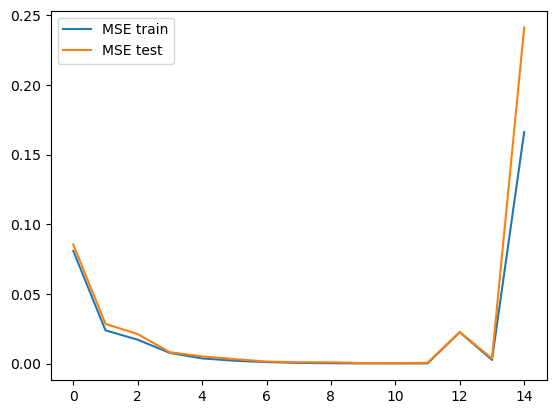

(320, 1) (400, 2)
(80, 21)
(21, 1)


In [41]:
#Trying now to split the data into training and testing

x_y_train, x_y_test, z_train, z_test = train_test_split(x_y, z.ravel().reshape(z.ravel().shape[0],1), test_size=0.2, random_state=42, shuffle=True)


maxdegree = 15
MSE_train = np.zeros(maxdegree)
MSE_test = np.zeros(maxdegree)
polydegree = np.zeros(maxdegree)

for i in range(maxdegree):
    # Training
    design_matrix_train = Design_Matrix_calc(i, x_y_train)
    betaOLS_= beta_calc(design_matrix_train, z_train)
    # Testing 
    design_matrix_test = Design_Matrix_calc(i, x_y_test)
    #Calculation of MSE of both training and test data sets
    ztilde_OLS= design_matrix_train @ betaOLS_
    zpredict_OLS = design_matrix_test @ betaOLS_
    MSE_train[i] = MSE(z_train, ztilde_OLS)
    MSE_test[i] = MSE(z_test, zpredict_OLS)
    polydegree[i] = i 

# Plot MSE error test
plt.plot(polydegree, MSE_train, label='MSE train')
plt.plot(polydegree, MSE_test, label='MSE test')
plt.legend()
plt.show()


print(z_train.shape, x_y.shape)
design_matrix_test = Design_Matrix_calc(5, x_y_test)
print(design_matrix_test.shape)

design_matrix_train = Design_Matrix_calc(5, x_y_train)
betaOLS_= beta_calc(design_matrix_train, z_train) 
print(betaOLS.reshape(betaOLS.ravel().shape[0],1).shape)

#the test size is the percentage of data we use as testing, in this case it's 20%
#random_stateint = controls the shuffling applied to the data before applying the split. Pass an int for reproducible output 
#                  across multiple function calls. See Glossary.
#shufflebool = whether or not to shuffle the data before splitting. If shuffle=False then stratify must be None.



In [42]:
#Calculation of MSE of both training and test data sets
ztilde_OLS= design_matrix_train @ betaOLS_
zpredict_OLS = design_matrix_test @ betaOLS_

print(MSE(z_train, ztilde_OLS))
print(MSE(z_test, zpredict_OLS))

0.0020445550694111483
0.003228556941246301


In [43]:
# Bootstrap and Bias-variance tradeoff

np.random.seed(2018)

n_boostraps = 100      # number of bootstrap sets
degree = 5              # degree of polynomial

# The following (m x n_bootstraps) matrix holds the column vectors y_pred
# for each bootstrap iteration.
z_pred = np.empty((z_test.shape[0], n_boostraps))

for i in range(n_boostraps):
    x_y_, z_ = resample(x_y_train, z_train)

    # Evaluate the new model on the same test data each time.
    design_matrix_train = Design_Matrix_calc(degree, x_y_)
    betaOLS_= beta_calc(design_matrix_train, z_)             #computing the beta
    #betaOLS_ = betaOLS_.reshape(betaOLS_.ravel().shape[0],1)
    design_matrix_test = Design_Matrix_calc(degree, x_y_test)
    z_pred[:, i] = (design_matrix_test @ betaOLS_).ravel()

# Note: Expectations and variances taken w.r.t. different training
# data sets, hence the axis=1. Subsequent means are taken across the test data
# set in order to obtain a total value, but before this we have error/bias/variance
# calculated per data point in the test set.
# Note 2: The use of keepdims=True is important in the calculation of bias as this 
# maintains the column vector form. Dropping this yields very unexpected results.


error = np.mean( np.mean((z_test - z_pred)**2, axis=1, keepdims=True) )
bias = np.mean( (z_test - np.mean(z_pred, axis=1, keepdims=True))**2 )
variance = np.mean( np.var(z_pred, axis=1, keepdims=True) )
print('Error:', error)
print('Bias^2:', bias)
print('Var:', variance)
print('{} >= {} + {} = {}'.format(error, bias, variance, bias+variance))


Error: 0.0036149399103408766
Bias^2: 0.003339600919344788
Var: 0.0002753389909960895
0.0036149399103408766 >= 0.003339600919344788 + 0.0002753389909960895 = 0.0036149399103408775
